# 오토인코더와 GAN을 사용한 표현 학습과 생성적 학습

먼저 몇 개의 모듈을 임포트한다. 맷플롯립 그림을 저장하는 함수를 준비한다.

In [1]:
try:
    IS_COLAB = True
except Exception:
    IS_COLAB = False
import tensorflow as tf
from tensorflow import keras

if not tf.config.list_physical_devices('GPU'):
    print('감지된 GPU가 없습니다. GPU가 없으면 LSTM과 CNN이 매우 느릴 수 있습니다.')
    if IS_COLAB:
        print('런타임 > 런타임 유형 변경 메뉴를 선택하고 하드웨어 가속기로 GPU를 고르세요.')
# 공통 모듈 임포트
import numpy as np
import os
# 깔끔한 그래프 출력을 위해
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
# 그림을 저장할 위치
PROJECT_ROOT_DIR = '.'
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, 'images')
os.makedirs(IMAGES_PATH, exist_ok=True)


def save_fig(fig_id, tight_layout=True, fig_extension='png', resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + '.' + fig_extension)
    print('그림 저장 ' + fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, dpi=resolution, format=fig_extension)

28x28 흑백 이미지를 그리기 위한 유틸리티 함수:

In [2]:
def plot_image(image):
    plt.imshow(image, 'binary')
    plt.axis('off')

## 과소완전 선형 오토인코더로 PCA 수행하기

3D 데이터셋을 만든다:

In [3]:
def generate_3d_data(m, w1=.1, w2=.3, noise=.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - .5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles) / 2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * .7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data


X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(0)

오토인코더를 만든다.

In [4]:
encoder = keras.Sequential([keras.layers.Dense(2, input_shape=[3])])
decoder = keras.Sequential([keras.layers.Dense(3, input_shape=[2])])
autoencoder = keras.Sequential([encoder, decoder])
autoencoder.compile(keras.optimizers.experimental.SGD(1.5), 'mse')

In [5]:
history = autoencoder.fit(X_train, X_train, epochs=20)

Epoch 1/20
2/2 [==============================] - 1s 5ms/step - loss: 0.2409
Epoch 2/20
2/2 [==============================] - 0s 5ms/step - loss: 0.0849
Epoch 3/20
2/2 [==============================] - 0s 4ms/step - loss: 0.0666
Epoch 4/20
2/2 [==============================] - 0s 3ms/step - loss: 0.0605
Epoch 5/20
2/2 [==============================] - 0s 4ms/step - loss: 0.0588
Epoch 6/20
2/2 [==============================] - 0s 3ms/step - loss: 0.0564
Epoch 7/20
2/2 [==============================] - 0s 4ms/step - loss: 0.0500
Epoch 8/20
2/2 [==============================] - 0s 4ms/step - loss: 0.0425
Epoch 9/20
2/2 [==============================] - 0s 4ms/step - loss: 0.0381
Epoch 10/20
2/2 [==============================] - 0s 4ms/step - loss: 0.0333
Epoch 11/20
2/2 [==============================] - 0s 4ms/step - loss: 0.0327
Epoch 12/20
2/2 [==============================] - 0s 4ms/step - loss: 0.0310
Epoch 13/20
2/2 [==============================] - 0s 4ms/step - loss: 0.

In [6]:
codings = encoder.predict(X_train)

2/2 [==============================] - 0s 2ms/step


그림 저장 linear_autoencoder_pca_plot


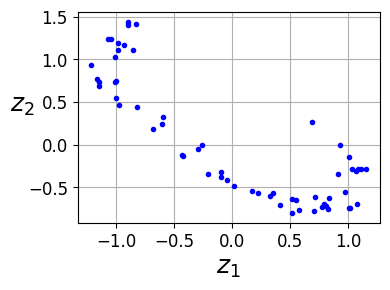

In [7]:
fig = plt.figure(figsize=(4, 3))
plt.plot(codings[:, 0], codings[:, 1], 'b.')
plt.xlabel('$z_1$', fontsize=18)
plt.ylabel('$z_2$', fontsize=18, rotation=0)
plt.grid(True)
save_fig('linear_autoencoder_pca_plot')
plt.show()

## 적층 오토인코더

### 케라스를 사용하여 적층 오토인코더 구현하기

MNIST 데이터셋을 사용한다:

In [8]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [9]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((55000, 28, 28), (55000,), (5000, 28, 28), (5000,), (10000, 28, 28), (10000,))

3개의 은닉층과 1개의 출력층(즉, 두 개를 적층)을 가진 적층 오토인코더를 만든다.

In [10]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.math.round(y_true), tf.math.round(y_pred))

In [11]:
stacked_encoder = keras.Sequential(
    [keras.layers.Flatten(input_shape=[28, 28]), keras.layers.Dense(100, 'selu'), keras.layers.Dense(30, 'selu')]
)
stacked_decoder = keras.Sequential(
    [
        keras.layers.Dense(100, 'selu', input_shape=[30]),
        keras.layers.Dense(28 * 28, 'sigmoid'),
        keras.layers.Reshape([28, 28])
    ]
)
stacked_ae = keras.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(keras.optimizers.experimental.SGD(1.5), 'binary_crossentropy', [rounded_accuracy])
# history = stacked_ae.fit(X_train, X_train, epochs=20, validation_data=(X_valid, X_valid))
history = stacked_ae.fit(X_train, X_train, epochs=4, validation_data=(X_valid, X_valid))

Epoch 1/4
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3355 - rounded_accuracy: 0.8892 - val_loss: 0.3110 - val_rounded_accuracy: 0.9104
Epoch 2/4
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3046 - rounded_accuracy: 0.9160 - val_loss: 0.3012 - val_rounded_accuracy: 0.9203
Epoch 3/4
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2979 - rounded_accuracy: 0.9220 - val_loss: 0.2978 - val_rounded_accuracy: 0.9261
Epoch 4/4
1719/1719 [==============================] - 8s 4ms/step - loss: 0.2937 - rounded_accuracy: 0.9259 - val_loss: 0.2931 - val_rounded_accuracy: 0.9278


### 재구성 시각화

이 함수는 오토인코더를 사용해 몇 개의 테스트 이미지를 처리한다. 그런 다음 원본 이미지와 재구성 이미지를 그린다:

In [12]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

1/1 [==============================] - 0s 65ms/step
그림 저장 reconstruction_plot


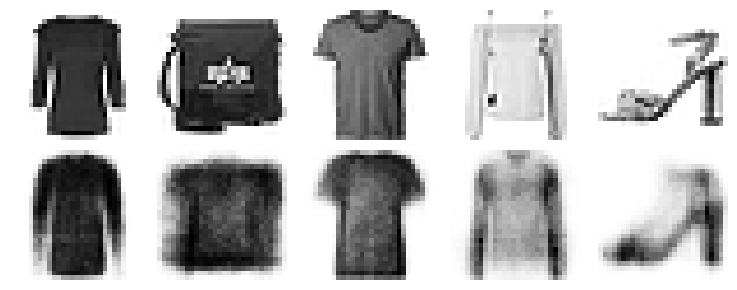

In [13]:
show_reconstructions(stacked_ae)
save_fig('reconstruction_plot')

### 패션 MNIST 데이터셋 시각화

In [14]:
from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

157/157 [==============================] - 0s 898us/step


C:\Users\kyun\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\kyun\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


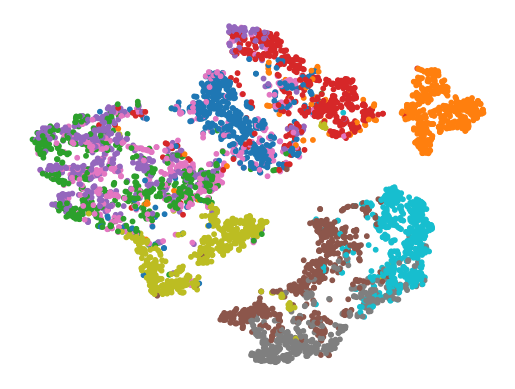

In [15]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], 10, y_valid, cmap='tab10')
plt.axis('off')
plt.show()

이 그림을 조금 더 예쁘게 그린다:

그림 저장 fashion_mnist_visualization_plot


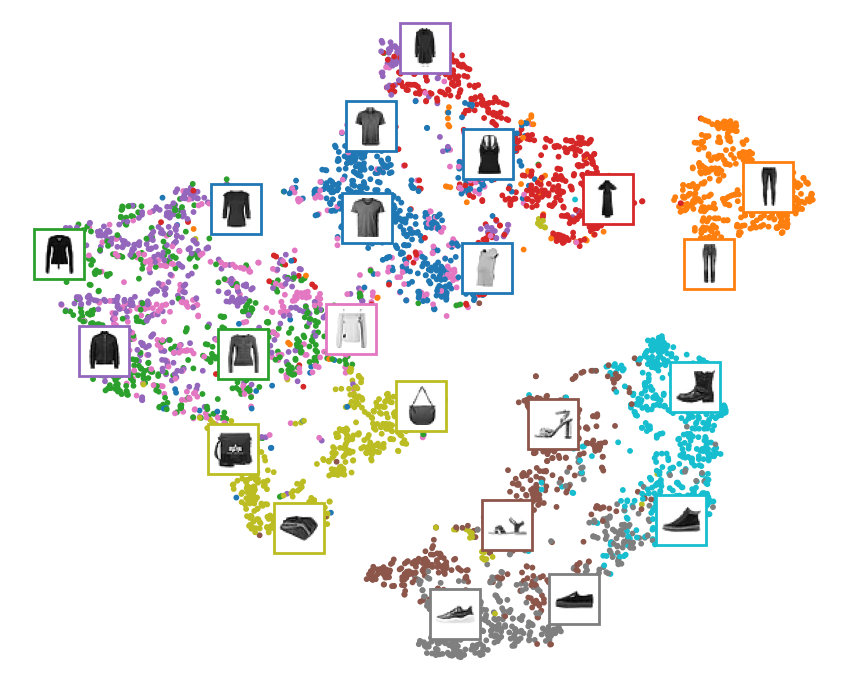

In [16]:
# https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html 참고
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], 10, y_valid, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, 1)
    if np.amin(dist) > .02:  # 다른 이미지에서 충분히 멀리 떨어져 있는 경우
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap='binary'),
            position,
            bboxprops={'edgecolor': cmap(y_valid[index]), 'lw': 2}
        )
        plt.gca().add_artist(imagebox)
plt.axis('off')
save_fig('fashion_mnist_visualization_plot')
plt.show()

### 가중치 묶기

인코더의 가중치를 전치(transpose)하여 디코더의 가중치로 사용하는 식으로 인코더와 디코더의 가중치를 묶는 일은 흔하다. 이렇게 하려면 사용자 정의 층을 사용해야 한다.

In [17]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.biases = None
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)

    def build(self, batch_input_shape):
        self.biases = self.add_weight('bias', [self.dense.input_shape[-1]], initializer='zeros')
        super().build(batch_input_shape)

    def call(self, inputs):
        z = tf.linalg.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

In [18]:
keras.backend.clear_session()
dense_1 = keras.layers.Dense(100, 'selu')
dense_2 = keras.layers.Dense(30, 'selu')
tied_encoder = keras.Sequential([keras.layers.Flatten(input_shape=[28, 28]), dense_1, dense_2])
tied_decoder = keras.Sequential(
    [DenseTranspose(dense_2, 'selu'), DenseTranspose(dense_1, 'sigmoid'), keras.layers.Reshape([28, 28])]
)
tied_ae = keras.Sequential([tied_encoder, tied_decoder])
tied_ae.compile(keras.optimizers.experimental.SGD(1.5), 'binary_crossentropy', [rounded_accuracy])
# history = tied_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))
history = tied_ae.fit(X_train, X_train, epochs=6, validation_data=(X_valid, X_valid))

Epoch 1/6
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3261 - rounded_accuracy: 0.8972 - val_loss: 0.3035 - val_rounded_accuracy: 0.9220
Epoch 2/6
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2963 - rounded_accuracy: 0.9237 - val_loss: 0.2944 - val_rounded_accuracy: 0.9242
Epoch 3/6
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2907 - rounded_accuracy: 0.9289 - val_loss: 0.2900 - val_rounded_accuracy: 0.9300
Epoch 4/6
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2877 - rounded_accuracy: 0.9314 - val_loss: 0.2882 - val_rounded_accuracy: 0.9303
Epoch 5/6
1719/1719 [==============================] - 8s 4ms/step - loss: 0.2859 - rounded_accuracy: 0.9330 - val_loss: 0.2877 - val_rounded_accuracy: 0.9337
Epoch 6/6
1719/1719 [==============================] - 8s 4ms/step - loss: 0.2845 - rounded_accuracy: 0.9341 - val_loss: 0.2864 - val_rounded_accuracy: 0.9311


1/1 [==============================] - 0s 65ms/step


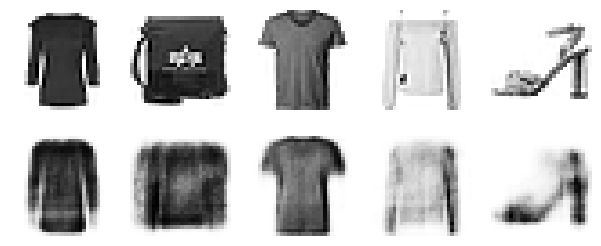

In [19]:
show_reconstructions(tied_ae)
plt.show()

### 한 번에 오토인코더 한 개씩 훈련하기

In [20]:
def train_autoencoder(n_neurons, X_train, X_valid, loss, optimizer, n_epochs=10, output_activation=None, metrics=None):
    n_inputs = X_train.shape[-1]
    encoder = keras.Sequential([keras.layers.Dense(n_neurons, 'selu', input_shape=[n_inputs])])
    decoder = keras.Sequential([keras.layers.Dense(n_inputs, output_activation)])
    autoencoder = keras.Sequential([encoder, decoder])
    autoencoder.compile(optimizer, loss, metrics)
    autoencoder.fit(X_train, X_train, epochs=n_epochs, validation_data=(X_valid, X_valid))
    return encoder, decoder, encoder(X_train), encoder(X_valid)

In [21]:
flatten = keras.layers.Flatten()
X_train_flat = flatten(X_train)  # .reshape(-1, 28 * 28)과 동일
X_valid_flat = flatten(X_valid)
enc1, dec1, X_train_enc1, X_valid_enc1 = train_autoencoder(
    100,
    X_train_flat,
    X_valid_flat,
    'binary_crossentropy',
    keras.optimizers.experimental.SGD(1.5),
    # output_activation='sigmoid',
    # metrics=[rounded_accuracy]
    8,
    'sigmoid',
    [rounded_accuracy]
)
enc2, dec2, _, _ = train_autoencoder(
    30, X_train_enc1, X_valid_enc1, 'mse', keras.optimizers.experimental.SGD(.05), output_activation='selu'
)

Epoch 1/8
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3446 - rounded_accuracy: 0.8876 - val_loss: 0.3109 - val_rounded_accuracy: 0.9158
Epoch 2/8
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3028 - rounded_accuracy: 0.9216 - val_loss: 0.2997 - val_rounded_accuracy: 0.9255
Epoch 3/8
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2942 - rounded_accuracy: 0.9294 - val_loss: 0.2929 - val_rounded_accuracy: 0.9325
Epoch 4/8
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2886 - rounded_accuracy: 0.9347 - val_loss: 0.2883 - val_rounded_accuracy: 0.9364
Epoch 5/8
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2849 - rounded_accuracy: 0.9383 - val_loss: 0.2852 - val_rounded_accuracy: 0.9394
Epoch 6/8
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2822 - rounded_accuracy: 0.9409 - val_loss: 0.2829 - val_rounded_accuracy: 0.9417
Epoch 7/8
1719/1719 [=========================

In [22]:
stacked_ae_1_by_1 = keras.Sequential(
    [keras.layers.Flatten(input_shape=[28, 28]), enc1, enc2, dec2, dec1, keras.layers.Reshape([28, 28])]
)

1/1 [==============================] - 0s 65ms/step


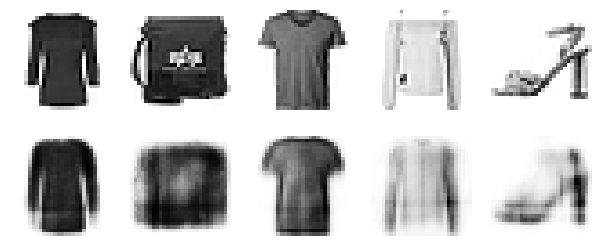

In [23]:
show_reconstructions(stacked_ae_1_by_1)
plt.show()

In [24]:
stacked_ae_1_by_1.compile(keras.optimizers.experimental.SGD(.1), 'binary_crossentropy', [rounded_accuracy])
# history = stacked_ae_1_by_1.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))
history = stacked_ae_1_by_1.fit(X_train, X_train, epochs=6, validation_data=(X_valid, X_valid))

Epoch 1/6
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2870 - rounded_accuracy: 0.9342 - val_loss: 0.2887 - val_rounded_accuracy: 0.9338
Epoch 2/6
1719/1719 [==============================] - 8s 4ms/step - loss: 0.2867 - rounded_accuracy: 0.9346 - val_loss: 0.2885 - val_rounded_accuracy: 0.9341
Epoch 3/6
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2865 - rounded_accuracy: 0.9348 - val_loss: 0.2883 - val_rounded_accuracy: 0.9344
Epoch 4/6
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2864 - rounded_accuracy: 0.9349 - val_loss: 0.2882 - val_rounded_accuracy: 0.9345
Epoch 5/6
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2862 - rounded_accuracy: 0.9350 - val_loss: 0.2880 - val_rounded_accuracy: 0.9348
Epoch 6/6
1719/1719 [==============================] - 8s 4ms/step - loss: 0.2861 - rounded_accuracy: 0.9351 - val_loss: 0.2879 - val_rounded_accuracy: 0.9348


1/1 [==============================] - 0s 66ms/step


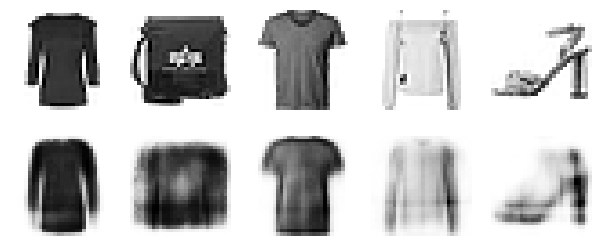

In [25]:
show_reconstructions(stacked_ae_1_by_1)
plt.show()

## 합성곱 오토인코더

3개의 은닉층과 1개의 출력층(즉, 두 개를 적층)을 가진 적층 오토인코더를 만든다.

In [26]:
conv_encoder = keras.Sequential(
    [
        keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
        keras.layers.Conv2D(16, 3, padding='same', activation='selu'),
        keras.layers.MaxPool2D(2),
        keras.layers.Conv2D(32, 3, padding='same', activation='selu'),
        keras.layers.MaxPool2D(2),
        keras.layers.Conv2D(64, 3, padding='same', activation='selu'),
        keras.layers.MaxPool2D(2)
    ]
)
conv_decoder = keras.Sequential(
    [
        keras.layers.Conv2DTranspose(32, 3, 2, activation='selu', input_shape=[3, 3, 64]),
        keras.layers.Conv2DTranspose(16, 3, 2, 'same', activation='selu'),
        keras.layers.Conv2DTranspose(1, 3, 2, 'same', activation='sigmoid'),
        keras.layers.Reshape([28, 28])
    ]
)
conv_ae = keras.Sequential([conv_encoder, conv_decoder])
conv_ae.compile(keras.optimizers.experimental.SGD(1.), 'binary_crossentropy', [rounded_accuracy])
# history = conv_ae.fit(X_train, X_train, epochs=5, validation_data=(X_valid, X_valid))
history = conv_ae.fit(X_train, X_train, epochs=4, validation_data=(X_valid, X_valid))

Epoch 1/4
1719/1719 [==============================] - 29s 8ms/step - loss: 0.3005 - rounded_accuracy: 0.9209 - val_loss: 0.2788 - val_rounded_accuracy: 0.9404
Epoch 2/4
1719/1719 [==============================] - 13s 8ms/step - loss: 0.2747 - rounded_accuracy: 0.9426 - val_loss: 0.2750 - val_rounded_accuracy: 0.9428
Epoch 3/4
1719/1719 [==============================] - 13s 7ms/step - loss: 0.2701 - rounded_accuracy: 0.9471 - val_loss: 0.2691 - val_rounded_accuracy: 0.9495
Epoch 4/4
1719/1719 [==============================] - 12s 7ms/step - loss: 0.2677 - rounded_accuracy: 0.9496 - val_loss: 0.2681 - val_rounded_accuracy: 0.9514


In [27]:
conv_encoder.summary()
conv_decoder.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_2 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)        

1/1 [==============================] - 0s 157ms/step


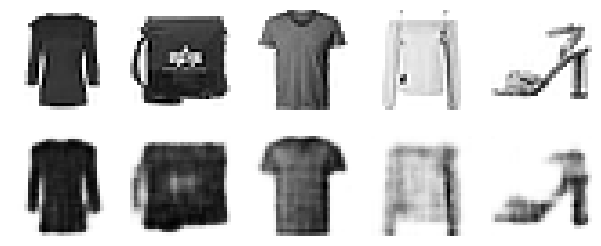

In [28]:
show_reconstructions(conv_ae)
plt.show()

## 순환 오토인코더

In [29]:
recurrent_encoder = keras.Sequential(
    [keras.layers.LSTM(100, return_sequences=True, input_shape=[28, 28]), keras.layers.LSTM(30)]
)
recurrent_decoder = keras.Sequential(
    [
        keras.layers.RepeatVector(28, input_shape=[30]),
        keras.layers.LSTM(100, return_sequences=True),
        keras.layers.TimeDistributed(keras.layers.Dense(28, 'sigmoid'))
    ]
)
recurrent_ae = keras.Sequential([recurrent_encoder, recurrent_decoder])
recurrent_ae.compile(keras.optimizers.experimental.SGD(.1), 'binary_crossentropy', [rounded_accuracy])

In [30]:
# history = recurrent_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))
history = recurrent_ae.fit(X_train, X_train, validation_data=(X_valid, X_valid))

1719/1719 [==============================] - 37s 18ms/step - loss: 0.5147 - rounded_accuracy: 0.7494 - val_loss: 0.4451 - val_rounded_accuracy: 0.8163


1/1 [==============================] - 1s 868ms/step


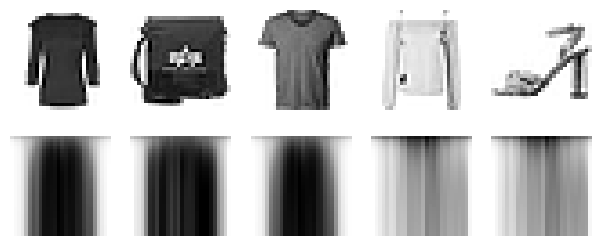

In [31]:
show_reconstructions(recurrent_ae)
plt.show()

## 잡음 제거 오토인코더

가우시안 잡음을 사용한다:

In [32]:
denoising_encoder = keras.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.GaussianNoise(.2),
        keras.layers.Dense(100, 'selu'),
        keras.layers.Dense(30, 'selu')
    ]
)
denoising_decoder = keras.Sequential(
    [
        keras.layers.Dense(100, 'selu', input_shape=[30]),
        keras.layers.Dense(28 * 28, 'sigmoid'),
        keras.layers.Reshape([28, 28])
    ]
)
denoising_ae = keras.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(keras.optimizers.experimental.SGD(1), 'binary_crossentropy', [rounded_accuracy])
# history = denoising_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))
history = denoising_ae.fit(X_train, X_train, epochs=6, validation_data=(X_valid, X_valid))

Epoch 1/6
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3473 - rounded_accuracy: 0.8797 - val_loss: 0.3169 - val_rounded_accuracy: 0.9086
Epoch 2/6
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3121 - rounded_accuracy: 0.9097 - val_loss: 0.3081 - val_rounded_accuracy: 0.9162
Epoch 3/6
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3054 - rounded_accuracy: 0.9155 - val_loss: 0.3027 - val_rounded_accuracy: 0.9183
Epoch 4/6
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3015 - rounded_accuracy: 0.9189 - val_loss: 0.2993 - val_rounded_accuracy: 0.9238
Epoch 5/6
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2988 - rounded_accuracy: 0.9212 - val_loss: 0.2966 - val_rounded_accuracy: 0.9255
Epoch 6/6
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2967 - rounded_accuracy: 0.9231 - val_loss: 0.2946 - val_rounded_accuracy: 0.9269


1/1 [==============================] - 0s 65ms/step


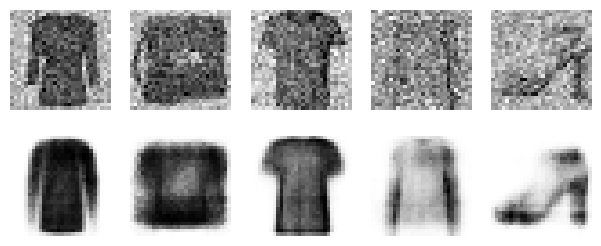

In [33]:
noise = keras.layers.GaussianNoise(.2)
show_reconstructions(denoising_ae, noise(X_valid, True))
plt.show()

드롭아웃을 사용한다:

In [34]:
dropout_encoder = keras.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dropout(.5),
        keras.layers.Dense(100, 'selu'),
        keras.layers.Dense(30, 'selu')
    ]
)
dropout_decoder = keras.Sequential(
    [
        keras.layers.Dense(100, 'selu', input_shape=[30]),
        keras.layers.Dense(28 * 28, 'sigmoid'),
        keras.layers.Reshape([28, 28])
    ]
)
dropout_ae = keras.Sequential([dropout_encoder, dropout_decoder])
dropout_ae.compile(keras.optimizers.experimental.SGD(1.), 'binary_crossentropy', [rounded_accuracy])
# history = dropout_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))
history = dropout_ae.fit(X_train, X_train, epochs=6, validation_data=(X_valid, X_valid))

Epoch 1/6
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3536 - rounded_accuracy: 0.8735 - val_loss: 0.3210 - val_rounded_accuracy: 0.9014
Epoch 2/6
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3178 - rounded_accuracy: 0.9036 - val_loss: 0.3111 - val_rounded_accuracy: 0.9125
Epoch 3/6
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3112 - rounded_accuracy: 0.9089 - val_loss: 0.3058 - val_rounded_accuracy: 0.9166
Epoch 4/6
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3078 - rounded_accuracy: 0.9116 - val_loss: 0.3031 - val_rounded_accuracy: 0.9195
Epoch 5/6
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3055 - rounded_accuracy: 0.9134 - val_loss: 0.3010 - val_rounded_accuracy: 0.9181
Epoch 6/6
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3037 - rounded_accuracy: 0.9148 - val_loss: 0.2986 - val_rounded_accuracy: 0.9226


1/1 [==============================] - 0s 66ms/step
그림 저장 dropout_denoising_plot


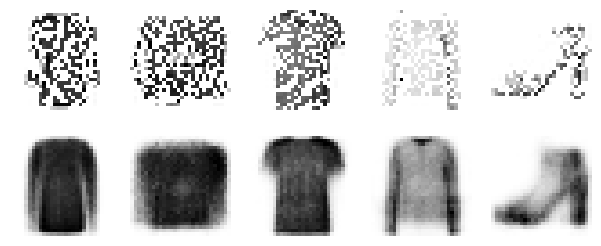

In [35]:
dropout = keras.layers.Dropout(.5)
show_reconstructions(dropout_ae, dropout(X_valid, True))
save_fig('dropout_denoising_plot', False)

## 희소 오토인코더

간단한 적층 오토인코더를 만들어 희소 오토인코더와 비교한다. 이번에는 코딩 층에 시그모이드 활성화 함수를 사용하여 코딩 값의 범위가 0~1 사이가 되도록 만든다:

In [36]:
simple_encoder = keras.Sequential(
    [keras.layers.Flatten(input_shape=[28, 28]), keras.layers.Dense(100, 'selu'), keras.layers.Dense(30, 'sigmoid')]
)
simple_decoder = keras.Sequential(
    [
        keras.layers.Dense(100, 'selu', input_shape=[30]),
        keras.layers.Dense(28 * 28, 'sigmoid'),
        keras.layers.Reshape([28, 28])
    ]
)
simple_ae = keras.Sequential([simple_encoder, simple_decoder])
simple_ae.compile(keras.optimizers.experimental.SGD(1.), 'binary_crossentropy', [rounded_accuracy])
# history = simple_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))
history = simple_ae.fit(X_train, X_train, epochs=6, validation_data=(X_valid, X_valid))

Epoch 1/6
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4309 - rounded_accuracy: 0.7964 - val_loss: 0.3773 - val_rounded_accuracy: 0.8485
Epoch 2/6
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3599 - rounded_accuracy: 0.8680 - val_loss: 0.3487 - val_rounded_accuracy: 0.8844
Epoch 3/6
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3368 - rounded_accuracy: 0.8889 - val_loss: 0.3323 - val_rounded_accuracy: 0.8948
Epoch 4/6
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3249 - rounded_accuracy: 0.8985 - val_loss: 0.3233 - val_rounded_accuracy: 0.9011
Epoch 5/6
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3192 - rounded_accuracy: 0.9028 - val_loss: 0.3214 - val_rounded_accuracy: 0.9054
Epoch 6/6
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3164 - rounded_accuracy: 0.9050 - val_loss: 0.3168 - val_rounded_accuracy: 0.9065


1/1 [==============================] - 0s 64ms/step


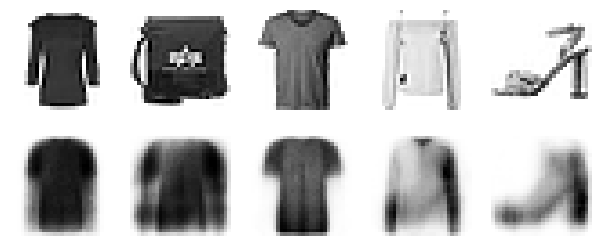

In [37]:
show_reconstructions(simple_ae)
plt.show()

활성화 히스토그램을 출력하기 위한 함수를 만든다:

In [38]:
def plot_percent_hist(ax, data, bins):
    counts, _ = np.histogram(data, bins)
    widths = bins[1:] - bins[:-1]
    x = bins[:-1] + widths / 2
    ax.bar(x, counts / len(data), widths * .8)
    ax.xaxis.set_ticks(bins)
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, position: f'{int(np.around(100 * y))}%'))
    ax.grid(True)

In [39]:
def plot_activations_histogram(encoder, height=1, n_bins=10):
    X_valid_codings = encoder(X_valid).numpy()
    activation_means = X_valid_codings.mean(0)
    mean = activation_means.mean()
    bins = np.linspace(0, 1, n_bins + 1)
    fig, [ax1, ax2] = plt.subplots(ncols=2, sharey=True, figsize=(10, 3))
    plot_percent_hist(ax1, X_valid_codings.ravel(), bins)
    ax1.plot([mean, mean], [0, height], 'k--', label=f'Overall Mean = {mean:.2f}')
    ax1.legend(loc='upper center', fontsize=14)
    ax1.set_xlabel('Activation')
    ax1.set_ylabel('% Activations')
    ax1.axis([0, 1, 0, height])
    plot_percent_hist(ax2, activation_means, bins)
    ax2.plot([mean, mean], [0, height], 'k--')
    ax2.set_xlabel('Neuron Mean Activation')
    ax2.set_ylabel('% Neurons')
    ax2.axis([0, 1, 0, height])

이 함수를 사용해 인코딩 층의 활성화에 대한 히스토그램을 출력한다. 왼쪽의 히스토그램은 전체 활성화의 분포이다. 0과 1에 가까운 값이 전체적으로 더 많다. 이는 시그모이드 함수가 포화되는 특성 때문이다. 오른쪽의 히스토그램은 평균 뉴런의 분포이다. 대부분의 뉴런이 0.5에 가까운 평균 활성화를 가진다. 두 히스토그램은 각 뉴런이 50% 확률로 0이나 1에 가까운 값에 활성화된다는 것을 보인다. 하지만 일부 뉴런은 거의 항상 활성화된다(오른쪽 히스토그램의 오른쪽편).

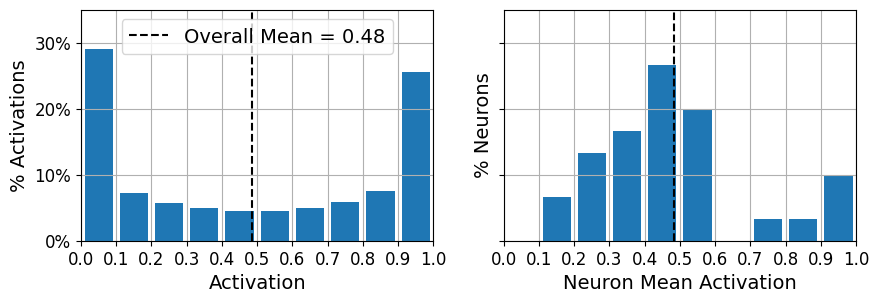

In [40]:
plot_activations_histogram(simple_encoder, .35)
plt.show()

코딩 층에 $\ell_1$ 규제를 추가한다:

In [41]:
sparse_l1_encoder = keras.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(100, 'selu'),
        keras.layers.Dense(300, 'sigmoid'),
        keras.layers.ActivityRegularization(1e-3)  # 또는 이전 레이어에 activity_regularizer=keras.regularizers.L1(1e-3)을 추가
    ]
)
sparse_l1_decoder = keras.Sequential(
    [
        keras.layers.Dense(100, 'selu', input_shape=[300]),
        keras.layers.Dense(28 * 28, 'sigmoid'),
        keras.layers.Reshape([28, 28])
    ]
)
sparse_l1_ae = keras.Sequential([sparse_l1_encoder, sparse_l1_decoder])
sparse_l1_ae.compile(keras.optimizers.experimental.SGD(1.), 'binary_crossentropy', [rounded_accuracy])
# history = sparse_l1_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))
history = sparse_l1_ae.fit(X_train, X_train, epochs=5, validation_data=(X_valid, X_valid))

Epoch 1/5
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4289 - rounded_accuracy: 0.8161 - val_loss: 0.3802 - val_rounded_accuracy: 0.8622
Epoch 2/5
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3693 - rounded_accuracy: 0.8693 - val_loss: 0.3657 - val_rounded_accuracy: 0.8678
Epoch 3/5
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3538 - rounded_accuracy: 0.8807 - val_loss: 0.3499 - val_rounded_accuracy: 0.8867
Epoch 4/5
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3433 - rounded_accuracy: 0.8881 - val_loss: 0.3436 - val_rounded_accuracy: 0.8863
Epoch 5/5
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3371 - rounded_accuracy: 0.8925 - val_loss: 0.3363 - val_rounded_accuracy: 0.8968


1/1 [==============================] - 0s 74ms/step


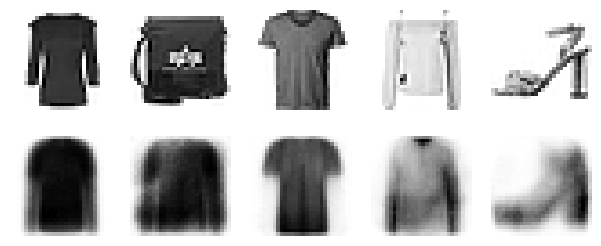

In [42]:
show_reconstructions(sparse_l1_ae)

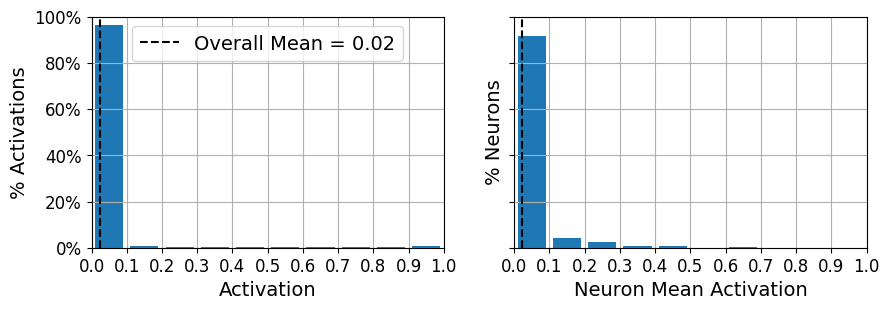

In [43]:
plot_activations_histogram(sparse_l1_encoder, 1.)
plt.show()

희소성을 위해 KL 발산을 사용하여 0%가 아니라 10% 희소성을 만든다:

그림 저장 sparsity_loss_plot


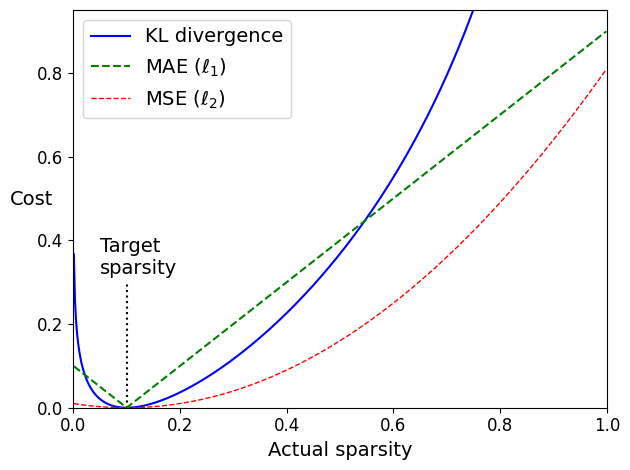

In [44]:
p = .1
q = np.linspace(.001, .999, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse = (p - q) ** 2
mae = np.absolute(p - q)
plt.plot([p, p], [0, .3], 'k:')
plt.text(.05, .32, 'Target\nsparsity', fontsize=14)
plt.plot(q, kl_div, 'b-', label='KL divergence')
plt.plot(q, mae, 'g--', label=r'MAE ($\ell_1$)')
plt.plot(q, mse, 'r--', linewidth=1, label=r'MSE ($\ell_2$)')
plt.legend(loc='upper left', fontsize=14)
plt.xlabel('Actual sparsity')
plt.ylabel('Cost', rotation=0)
plt.axis([0, 1, 0, 0.95])
save_fig('sparsity_loss_plot')

In [45]:
kl_divergence = keras.metrics.kl_divergence


class KLDivergenceRegularizer(keras.regularizers.Regularizer):
    def __init__(self, weight, target=0.1):
        self.weight = weight
        self.target = target

    def __call__(self, inputs):
        mean_activities = tf.math.reduce_mean(inputs, 0)
        return self.weight * (
                kl_divergence(self.target, mean_activities) + kl_divergence(1. - self.target, 1. - mean_activities)
        )

In [46]:
kld_reg = KLDivergenceRegularizer(.05)
sparse_kl_encoder = keras.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(100, 'selu'),
        keras.layers.Dense(300, 'sigmoid', activity_regularizer=kld_reg)
    ]
)
sparse_kl_decoder = keras.Sequential(
    [
        keras.layers.Dense(100, 'selu', input_shape=[300]),
        keras.layers.Dense(28 * 28, 'sigmoid'),
        keras.layers.Reshape([28, 28])
    ]
)
sparse_kl_ae = keras.Sequential([sparse_kl_encoder, sparse_kl_decoder])
sparse_kl_ae.compile(keras.optimizers.experimental.SGD(1.), 'binary_crossentropy', [rounded_accuracy])
# history = sparse_kl_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))
history = sparse_kl_ae.fit(X_train, X_train, epochs=4, validation_data=(X_valid, X_valid))

Epoch 1/4
1719/1719 [==============================] - 11s 6ms/step - loss: 0.4124 - rounded_accuracy: 0.8155 - val_loss: 0.3692 - val_rounded_accuracy: 0.8626
Epoch 2/4
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3507 - rounded_accuracy: 0.8789 - val_loss: 0.3416 - val_rounded_accuracy: 0.8874
Epoch 3/4
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3319 - rounded_accuracy: 0.8937 - val_loss: 0.3272 - val_rounded_accuracy: 0.8998
Epoch 4/4
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3211 - rounded_accuracy: 0.9028 - val_loss: 0.3208 - val_rounded_accuracy: 0.9055


1/1 [==============================] - 0s 86ms/step


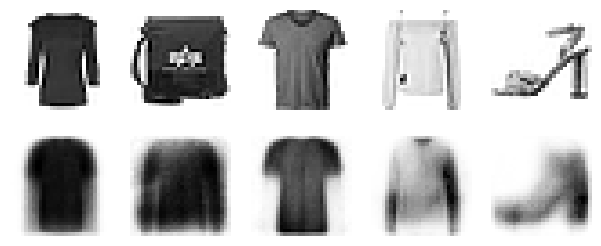

In [47]:
show_reconstructions(sparse_kl_ae)

그림 저장 sparse_autoencoder_plot


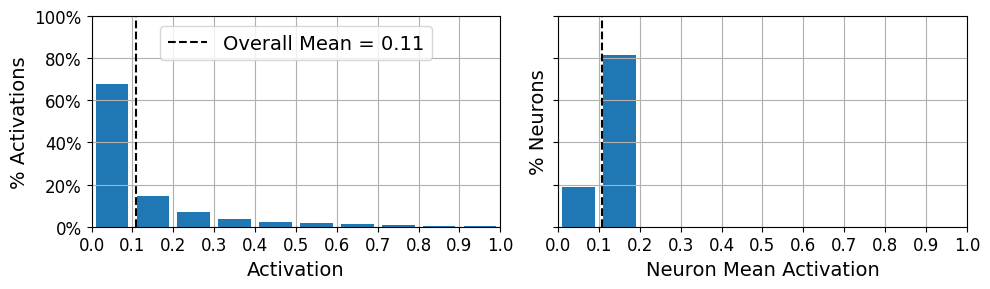

In [48]:
plot_activations_histogram(sparse_kl_encoder)
save_fig('sparse_autoencoder_plot')
plt.show()

## 변이형 오토인코더